<div align="center">
  <h1><b>Sentiment Analysis on Ibu Kota Nusantara on X</b></h1>
</div>

## **Introduction**  
Public sentiment plays a crucial role in shaping discussions and perceptions about major national projects. One such project in **Indonesia is Ibu Kota Nusantara (IKN)**, the country’s new capital city. As debates about its development continue, social media platforms like Twitter (X) have become key spaces where people express their opinions, concerns, and support.

This study aims to **analyze the sentiment surrounding IKN on Twitter (X)** by collecting and processing posts related to the topic. Using the Indonesian Sentiment Lexicon, we classify sentiments as positive, negative, or neutral, providing insights into public perception. The results of this analysis can **help investors, including those from companies whose stocks are affected by IKN** sentiment (e.g., **BUMN** companies, **TELKOM**, and other IPO companies), as well as **foreign investors**, understand how people feel about the project and its progress. This enables them to make more informed decisions regarding investments related to the development of IKN.

---

## **Overview of the Analysis**  
### **Purpose**  
The goal of this sentiment analysis was to classify text data (e.g., social media posts, product reviews, etc.) into sentiment categories such as positive, negative, or neutral.

### **Data Used**  
The analysis used a dataset of posts on Twitter (X) related to a particular topic (e.g., Ibu Kota Nusantara (IKN)).

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

pd.options.mode.chained_assignment = None
seed = 0
np.random.seed(seed)
sns.set(style = 'whitegrid')
# import twint
import nest_asyncio
nest_asyncio.apply()


import datetime as dt
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from wordcloud import WordCloud

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Embedding, Dense, Dropout, LSTM
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import EarlyStopping

from scikeras.wrappers import KerasClassifier, KerasRegressor


from sklearn.model_selection import GridSearchCV
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [4]:
# Download the required tokenizer for Indonesian
# nltk.download('punkt_tab')
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

In [5]:
df = pd.read_csv('IKN.CSV').drop(columns=['Unnamed: 0', 'Repost_Count.1'], errors='ignore')

## Column Descriptions

| **Column Name**          | **Description** |
|--------------------------|----------------|
| **Post_ID**              | Unique identifier for each tweet. |
| **Author_Name**          | Display name of the user who posted the tweet. |
| **Author_Web_Page_URL**  | URL to the author's profile page. |
| **Author_Handle**        | The Twitter (X) username of the author (e.g., @username). |
| **Verified_Status**      | Indicates whether the author is verified (e.g., "Verified" or "Not Verified"). |
| **UTC_Time**             | The timestamp of when the tweet was posted, in UTC format. |
| **Ads**                  | Boolean value (`True`/`False`) indicating whether the tweet is an advertisement. |
| **Tweet_Content**        | The actual text content of the tweet. |
| **Reply_Count**          | Number of replies the tweet has received. |
| **Repost_Count**         | Number of times the tweet has been reposted (formerly retweeted). |
| **Like_Count**           | Number of likes the tweet has received. |
| **View_Count**           | Number of views the tweet has received. |
| **Reply_to_Whom_Handle** | The Twitter handle of the user to whom the tweet is replying (if applicable). |


## Data Cleaning & Preprocessing

### Check for Duplicated Data

In [9]:
df.duplicated().sum()

0

> This dataset does not contain duplicated data

### Check for Missing Values

In [12]:
pip install notebook --upgrade

Note: you may need to restart the kernel to use updated packages.


In [13]:
def missing_values_table(data):
    miss_val_count = data.isnull().sum()
    miss_val_percent = ((miss_val_count / len(data)) * 100).round(2).astype(str)+'%'
    table = pd.concat([miss_val_count, miss_val_percent], axis=1)
    table.columns = ['Total Missing Values', 'Proportion of Missing Values']
    table = table[table['Total Missing Values'] != 0].sort_values('Proportion of Missing Values', ascending=False).round(2)
    return table

df_missing_values = missing_values_table(df)
display(df_missing_values)

,Total Missing Values,Proportion of Missing Values
Reply_to_Whom_Handle,15326,90.62%
Post_ID,1,0.01%
Author_Name,1,0.01%
Author_Handle,1,0.01%
Verified_Status,1,0.01%
UTC_Time,1,0.01%
Tweet_Content,1,0.01%
Reply_Count,1,0.01%


In [14]:
df[df['Post_ID'].isna()]

,Post_ID,Author_Name,Author_Web_Page_URL,Author_Handle,Verified_Status,UTC_Time,Ads,Tweet_Content,Reply_Count,Repost_Count,Like_Count,View_Count,Reply_to_Whom_Handle
1614,NaN,NaN,https://x.com/BarronIndra,NaN,NaN,NaN,False,NaN,NaN,0,0,0,NaN


In [15]:
df = df.dropna(subset=['Post_ID'])

> Drop any row where all columns contain missing values.

In [16]:
df['Reply_to_Whom_Handle'] = df['Reply_to_Whom_Handle'].fillna('-')

> Fill missing values in the `Reply_to_Whom_Handle` column with `'-'`, as this field is not relevant for all tweets.

In [17]:
def missing_values_table(data):
    miss_val_count = data.isnull().sum()
    miss_val_percent = ((miss_val_count / len(data)) * 100).round(2).astype(str)+'%'
    table = pd.concat([miss_val_count, miss_val_percent], axis=1)
    table.columns = ['Total Missing Values', 'Proportion of Missing Values']
    table = table[table['Total Missing Values'] != 0].sort_values('Proportion of Missing Values', ascending=False).round(2)
    return table

df_missing_values = missing_values_table(df)
display(df_missing_values)

,Total Missing Values,Proportion of Missing Values


>The data is clean with no missing values remaining.

### Cek Apakah Tweet tidak mengandung keywords yang ingin di analisa

In [19]:
### Cek Apakah Tweet tidak mengandung keywords yang ingin di analisa
df[~df['Tweet_Content'].str.lower().str.contains(r'ikn|ibu kota nusantara|ibukotanusantara', na=False)]

,Post_ID,Author_Name,Author_Web_Page_URL,Author_Handle,Verified_Status,UTC_Time,Ads,Tweet_Content,Reply_Count,Repost_Count,Like_Count,View_Count,Reply_to_Whom_Handle


> All posts contain the specified keywords, so no rows need to be filtered out.

# Exploratory Data Analysis

In [86]:
df_eda = df.copy()

In [87]:
df_eda['UTC_Time'] = pd.to_datetime(df_eda['UTC_Time'], utc=True)

df_eda['GMT+7_Time'] = df_eda['UTC_Time'].dt.tz_convert('Asia/Bangkok')  # GMT+7 is 'Asia/Bangkok'

df_eda['hour'] = df_eda['GMT+7_Time'].dt.hour

tweet_counts_by_hour = df_eda.groupby('hour').size()

tweet_counts_by_hour = tweet_counts_by_hour.reset_index(name='tweet_count')

C:\Users\muham\AppData\Local\Temp\ipykernel_14292\3477554663.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='hour', y='tweet_count', data=tweet_counts_by_hour, palette='viridis')


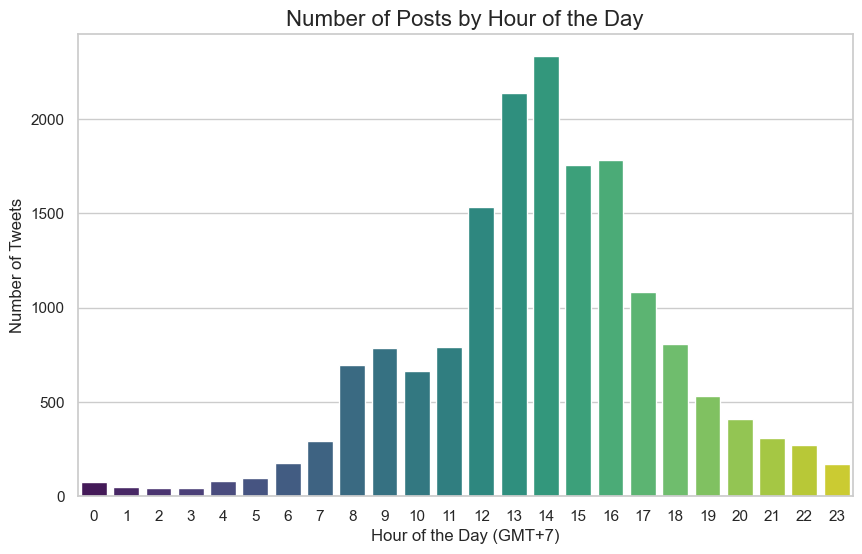

In [88]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.barplot(x='hour', y='tweet_count', data=tweet_counts_by_hour, palette='viridis')

plt.title('Number of Posts by Hour of the Day', fontsize=16)
plt.xlabel('Hour of the Day (GMT+7)', fontsize=12)
plt.ylabel('Number of Tweets', fontsize=12)
plt.xticks(range(24))  

plt.show()

> By analyzing the distribution of posts by the hour, we observed that the highest post activity occurs between 6 and 8 UTC, peaking at 7 UTC. This indicates that the audience is most active during these hours, which can be valuable information for scheduling tweets for maximum visibility and engagement.

In [90]:
df_eda['month'] = df_eda['GMT+7_Time'].dt.month

C:\Users\muham\AppData\Local\Temp\ipykernel_14292\3758981455.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='year_month', y='tweet_count', data=tweet_counts_by_month, palette='viridis')


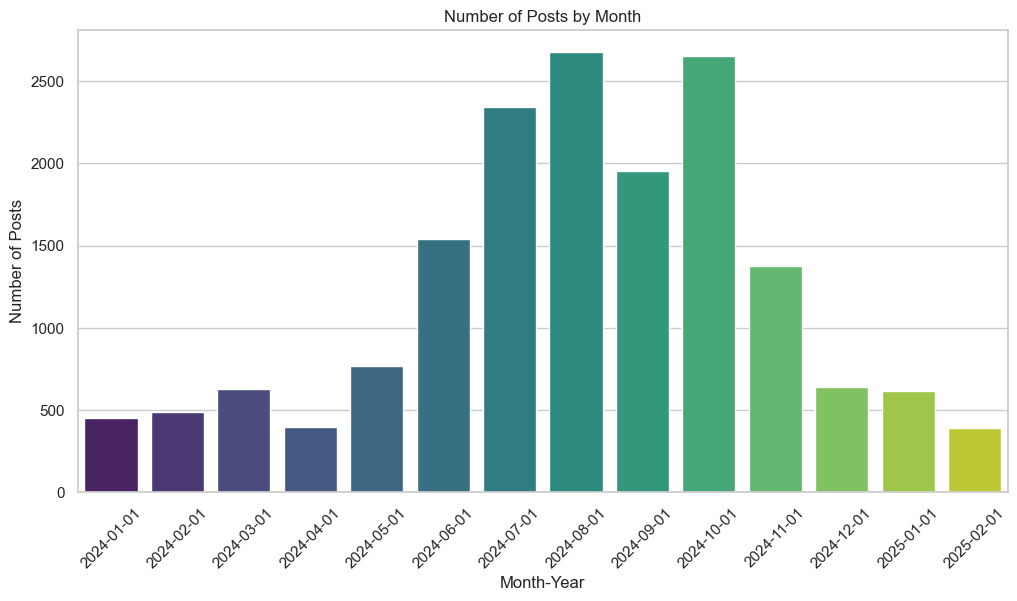

In [92]:
df_eda['year_month'] = df_eda['UTC_Time'].dt.strftime('%b %Y')  # Format: "Jan 2024"

# Group by "year_month" and count posts
tweet_counts_by_month = df_eda.groupby('year_month').size().reset_index(name='tweet_count')

tweet_counts_by_month['year_month'] = pd.to_datetime(tweet_counts_by_month['year_month'], format='%b %Y')
tweet_counts_by_month = tweet_counts_by_month.sort_values('year_month')

plt.figure(figsize=(12, 6))
sns.barplot(x='year_month', y='tweet_count', data=tweet_counts_by_month, palette='viridis')

plt.title("Number of Posts by Month")
plt.xlabel("Month-Year", fontsize=12)
plt.ylabel("Number of Posts", fontsize=12)
plt.xticks(rotation=45)  # Rotate labels
plt.show()

> Observing a peak in tweet activity during **July, August, and September 2024** likely points to specific events or announcements related to IKN that captured public interest. This seasonal or event-driven spike can be crucial for understanding the dynamics of public engagement and sentiment around the project.

## Posts with Highest Engagement Rate

In [95]:
df_eda["Engagement_Rate"] = (
    (df_eda["Reply_Count"] + df_eda["Repost_Count"] + df_eda["Like_Count"]) / df_eda["View_Count"]
).replace([float('inf'), float('-inf')], 0) * 100

In [96]:
pd.set_option('display.max_colwidth', None)
sorted_tweets = df_eda.sort_values(by='Engagement_Rate', ascending=False)
selected_columns = ['Author_Name', 'Author_Handle', 'Verified_Status', 'Tweet_Content', 'Reply_Count', 'Repost_Count', 'Like_Count', 'View_Count', 'Engagement_Rate']
sorted_tweets[selected_columns].head()

,Author_Name,Author_Handle,Verified_Status,Tweet_Content,Reply_Count,Repost_Count,Like_Count,View_Count,Engagement_Rate
15771,Nusantara Monitor,NusantaraMonit,True,Optimisme terhadap pembangunan IKN mencerminkan tekad bersama untuk menciptakan Indonesia yang lebih baik di masa depan. 💪🏼\n\n#IKN\n#PembangunanIKN\n#PemerataanEkonomi\n#PemerataanPembangunan https://t.co/coV3gf8ZN6,155.0,6,11,76,226.315789
16428,Nusantara Monitor,NusantaraMonit,True,"Pemerintah Prabowo-Gibran: Teguh Melanjutkan IKN, Tegas Membangun Indonesia. 🏢💡 Masa depan mulai dirancang di sini!\n#IKN #LanjutkanIKN #100HariPemerintahanPrabowoGibran https://t.co/aTOJlrSAT4",92.0,6,8,47,225.531915
16011,Nusantara Monitor,NusantaraMonit,True,TNI AU memastikan kesiapan sistem pertahanan udara di IKN sebagai langkah strategis untuk menjaga keamanan dan kedaulatan wilayah udara Indonesia. 💪🏼🏞️✈️\n\n#IKN\n#IKNNusantara\n#KeamananUdaraIKN\n#PemerataanEkonomi https://t.co/6NNqdYZRr6,157.0,8,10,81,216.049383
12057,jesi jacinda,jesijacinda,False,Menteri PPN memeriksa kesiapan pemindahan ASN ke IKN untuk memastikan transisi yang lancar. #IbuKotaNegaraNusantara #IKN #IKNNusantara #IndonesiaEmas2045 #SmartCity #KotaModern #IndonesiaMaju https://t.co/rqpgUNgT4m,1.0,0,1,1,200.000000
13950,Waode islaysin,waode_islaysin,False,Wujudkan kota modern utk menyongsong Indonesia Emas 2045! #IbuKotaNegaraNusantara #IKN #IKNNusantara #IndonesiaEmas2045 #SmartCity #KotaModern #IndonesiaMaju #KerjaNyataJokowi #JokowiMerakyat #JokowiBerdedikasi #KaryaNyata https://t.co/aIhPbQuW4v,1.0,0,1,1,200.000000


> Given the high engagement rates, especially from verified accounts, there's a possibility that these accounts are strategically used to amplify positive sentiments about IKN. Buzzers are often used to drive specific narratives or promote certain topics.

## Top Liked Accounts

In [99]:
# Group by Author_Handle and aggregate likes
top_liked_accounts = df_eda.groupby('Author_Handle')['Like_Count'].sum().reset_index()

# Sort by the total number of likes in descending order
top_liked_accounts = top_liked_accounts.sort_values(by='Like_Count', ascending=False)

# Show the top 10 liked accounts
top_liked_accounts.head(10)

,Author_Handle,Like_Count
1571,tempodotco,14330
920,blackshark7890,9075
1251,kompascom,6861
1445,projectm_org,3392
369,KATADATAcoid,2488
426,Lembayung071,2220
7,21_mozza,1757
10,3rwin__34,1515
465,Metro_TV,1135
568,Poldakaltim,1113


> **tempodotco (@tempodotco):** With 14,330 likes, this account tops the list. This suggests that tempodotco has significant influence and its tweets are highly engaging. As a national media outlet, Tempo has a broad reach and credibility, which likely contributes to the high engagement levels.

>**blackshark7890 (@blackshark7890):** With 9,075 likes, this account also demonstrates high engagement. Despite not being a national media outlet, blackshark7890 manages to capture a significant amount of user interaction.

>**kompascom (@kompascom):** Garnering 6,861 likes, indicating high credibility and engagement with the audience. As another national media outlet, Kompas also benefits from its established reputation and wide readership, which drives higher engagement on its tweets.

### Text Preprocessing

In [20]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'RT[\s]', '', text)
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r'[0-9]+', '', text)

    text = text.replace('\n', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip(' ')
    return text

def casefoldingText(text):
    text = text.lower()
    return text

def tokenizingText(text):
    text = word_tokenize(text)
    return text

def stemmingText(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    text = [stemmer.stem(word) for word in text]
    return text

def toSentence(list_words):
    sentence = ' '.join(word for word in list_words)
    return sentence

In [21]:
import pandas as pd

# Slang words dictionary
slang_words = {
    'gk': 'gak', 'ga': 'gak', 'nggak': 'gak', 'krn': 'karena', 'knp': 'kenapa',
    'ap': 'apa', 'tp': 'tapi', 'bgt': 'banget', 'bgd': 'banget', 'bnget': 'banget',
    'gt': 'gitu', 'jg': 'juga', 'jgn': 'jangan', 'skg': 'sekarang', 'tdk': 'tidak',
    'gw': 'saya', 'gue': 'saya', 'lu': 'kamu', 'lo': 'kamu', 'nih': 'ini',
    'aja': 'saja', 'klo': 'kalau', 'dr': 'dari', 'sm': 'sama', 'knpa': 'kenapa',
    'ngapain': 'kenapa', 'btw': 'by the way', 'om': 'saya', 'tante': 'saya',
    'mas': 'saya', 'mba': 'saya', 'bro': 'saya', 'sis': 'saya', 'kak': 'saya',
    'cuma': 'hanya', 'abis': 'habis', 'deh': '', 'dah': 'sudah', 'udh': 'udah',
    'bener': 'benar', 'bgtu': 'begitu', 'bgtuh': 'begitu', 'emg': 'memang',
    'sih': '', 'dong': '', 'jln': 'jalan', 'gmn': 'bagaimana', 'pokoknya': '',
    'jd': 'jadi', 'w': 'saya', 'aku': 'saya', 'kamu': 'kamu', 'kita': 'kami',
    'kalian': 'mereka', 'mereka': 'mereka', 'yg': 'yang', 'sdh': 'sudah',
    'dgn': 'dengan', 'lg': 'lagi', 'tau': 'tahu', 'smua': 'semua', 'bngt': 'banget',
    'bngtz': 'banget', 'msk': 'masuk', 'ad': 'ada', 'dpt': 'dapat', 'msh': 'masih',
    'jm': 'jam', 'dlm': 'dalam', 'utk': 'untuk', 'lbh': 'lebih', 'krja': 'kerja',
    'kyk': 'kayak', 'pn': 'pun', 'ktnya': 'katanya', 'slh': 'salah', 'bkn': 'bukan',
    'sy': 'saya', 'mlm': 'malam', 'tuh': 'itu', 'lbih': 'lebih', 'dkit': 'sedikit',
    'mslh': 'masalah', 'org': 'orang', 'skali': 'sekali', 'mreka': 'mereka',
    'emang': 'memang', 'wktu': 'waktu', 'bnyk': 'banyak', 'mlh': 'malah',
    'dri': 'dari', 'bbrp': 'beberapa', 'tpi': 'tapi', 'nnti': 'nanti',
    'si': '', 'hehe': '', 'hihi': '', 'haha': '', 'hooh': '', 'hu': '',
    'wk': '', 'wkwk': '', 'hore': '', 'yuhuu': '',
}

# Convert to DataFrame
df_slang = pd.DataFrame(list(slang_words.items()), columns=['original', 'replacement'])

In [22]:
df_slang_map = dict(zip(df_slang['original'], df_slang['replacement']))
def removeSlangWords(text):
    if isinstance(text, list):  # Convert lists to strings
        text = ' '.join(map(str, text))
    elif not isinstance(text, str):  # Convert non-string values (e.g., NaN, numbers) to empty string
        text = ''
    
    return ' '.join([df_slang_map[word] if word in df_slang_map else word for word in text.split()])

In [23]:
alay_dict = pd.read_csv('new_kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original', 
                                      1: 'replacement'})
id_stopword_dict = pd.read_csv('stopwordbahasa.csv', header=None)
id_stopword_dict = id_stopword_dict.rename(columns={0: 'stopword'})

In [24]:
alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    if isinstance(text, list):  # Convert lists to strings
        text = ' '.join(map(str, text))
    elif not isinstance(text, str):  # Convert non-string values (e.g., NaN, numbers) to empty string
        text = ''
    
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split()])

def remove(text): #Stopwords
    text = ' '.join(['' if word in id_stopword_dict.stopword.values else word for word in text.split(' ')])
    text = re.sub('  +', ' ', text) # Remove extra spaces
    text = text.strip()
    return text

In [25]:
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemming(text):
    return stemmer.stem(text)

In [26]:
import nltk
import os

nltk.download('punkt')
nltk.data.path.append("nltk_data")
nltk.download('stopwords', download_dir="nltk_data")
print(nltk.data.find('corpora/stopwords'))

C:\Users\muham\Downloads\nltk_data\corpora\stopwords


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\muham\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Remove Buzzer

In [28]:
user_stats = df.groupby('Author_Handle').agg(
    total_posts=('Post_ID', 'count'),
    mean_likes=('Like_Count', 'mean'),
    mean_replies=('Reply_Count', 'mean'),
    mean_views=('View_Count', 'mean')
).reset_index()

# Define thresholds for suspicious activity
post_threshold = 50  # More than 50 posts
like_threshold = 2    # Very low average likes
reply_threshold = 1   # Very low average replies
view_threshold = 100  # Very low average views

# Identify suspicious (buzzer) accounts
suspicious_accounts = user_stats[
    (user_stats['total_posts'] > post_threshold) & 
    (user_stats['mean_likes'] < like_threshold) & 
    (user_stats['mean_replies'] < reply_threshold) & 
    (user_stats['mean_views'] < view_threshold)
]['Author_Handle'].tolist()

# Remove buzzer accounts from dataset
df_filtered = df[~df['Author_Handle'].isin(suspicious_accounts)]

In [29]:
tweets = df_filtered.copy()

In [30]:
tweets['text_clean'] = tweets['Tweet_Content'].apply(cleaningText) ## Unique character
tweets['text_clean'] = tweets['text_clean'].apply(casefoldingText) ## Lower Case
tweets['text_clean'] = tweets['text_clean'].apply(removeSlangWords)
tweets['text_clean'] = tweets['text_clean'].apply(normalize_alay)
# tweets.drop(['Tweet_Content'], axis = 1, inplace = True)

In [31]:
tweets['Text_final'] = tweets['text_clean'].apply(remove)
tweets['Text_final'] = tweets['Text_final'].apply(stemming)

In [32]:
tweets['text_token'] = tweets['Text_final'].apply(tokenizingText) 
tweets['text_token2'] = tweets['text_clean'].apply(tokenizingText) 

In [33]:
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import string

dictionary = corpora.Dictionary(tweets['text_token'])
corpus = [dictionary.doc2bow(text) for text in tweets['text_token']]
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, random_state=42, passes=10)
coherence_model = CoherenceModel(model=lda_model, texts=tweets['text_token'], dictionary=dictionary, coherence='c_v')
coherence = coherence_model.get_coherence()
topics_df = pd.DataFrame(columns=['Validation_Set', 'Topics', 'Alpha', 'Beta', 'Coherence'])
topics_df.loc[0] = ['Final_IKN.csv', 5, 'auto', 'auto', coherence]
lda_display = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

In [34]:
positive=pd.read_csv('positive.tsv',sep='\t',header=1)
negative=pd.read_csv('negative.tsv',sep='\t',header=1)
# positive.to_csv('positive.csv',index=False)
# negative.to_csv('negative.csv',index=False)
positive

,hai,3
0,merekam,2
1,ekstensif,3
2,paripurna,1
3,detail,2
4,pernik,3
...,...,...
3603,melarikan,3
3604,vakansi,3
3605,spesial,4
3606,asrama,3


## Sentiment Polarity using Indonesia Sentiment Lexicon.
Source : [Indonesia Sentiment Lexicon.](https://github.com/fajri91/InSet)

In [35]:
# MENGGUNAKAN indonesia sentiment lexicon (source : https://github.com/fajri91/InSet)

lexicon_positive = dict()
import csv
with open('positive.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        lexicon_positive[row[0]] = int(row[1])

lexicon_negative = dict()
import csv
with open('negative.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])


def sentiment_analysis_lexicon_indonesia(text):
    score = 0
    for word in text:
        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
    for word in text:
        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
    polarity=''
    if (score > 0):
        polarity = 'positive'
    elif (score < 0):
        polarity = 'negative'
    else:
        polarity = 'neutral'
    return score, polarity

In [36]:
results = tweets['text_token2'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
tweets['polarity_score'] = results[0]
tweets['polarity'] = results[1]
print(tweets['polarity'].value_counts())

# btweets.to_csv(r'IKN_clean_polarity.csv', index = False, header = True,index_label=None)

tweets

polarity
negative    4394
positive    3262
neutral      969
Name: count, dtype: int64


,Post_ID,Author_Name,Author_Web_Page_URL,Author_Handle,Verified_Status,UTC_Time,Ads,Tweet_Content,Reply_Count,Repost_Count,Like_Count,View_Count,Reply_to_Whom_Handle,text_clean,Text_final,text_token,text_token2,polarity_score,polarity
0,1.741833e+18,JatengNOW,https://x.com/Jateng_now,Jateng_now,False,2024-01-01 14:45:53+00:00,False,Prabowo-Gibran Siapkan Konsep 10 Kota Teknolog...,0.0,0,0,29,-,prabowogibran siapkan konsep kota teknologi di...,prabowogibran siap konsep kota teknologi indon...,"[prabowogibran, siap, konsep, kota, teknologi,...","[prabowogibran, siapkan, konsep, kota, teknolo...",-1,negative
1,1.742116e+18,Kompas.com,https://x.com/kompascom,kompascom,True,2024-01-02 09:29:00+00:00,False,"Pada tahun 2045 mendatang, pembangunan kawasan...",0.0,1,1,1299,-,pada tahun mendatang pembangunan kawasan inti ...,bangun kawasan inti pusat perintah kipp target...,"[bangun, kawasan, inti, pusat, perintah, kipp,...","[pada, tahun, mendatang, pembangunan, kawasan,...",11,positive
2,1.742041e+18,DetikFinance,https://x.com/detikfinance,detikfinance,False,2024-01-02 04:33:24+00:00,False,September lalu Badan Otorita IKN melakukan rap...,6.0,16,12,7221,-,september lalu badan otorita ikn melakukan rap...,september badan otorita ikn rapat banggar dewa...,"[september, badan, otorita, ikn, rapat, bangga...","[september, lalu, badan, otorita, ikn, melakuk...",-13,negative
3,1.742198e+18,Guvir Sport,https://x.com/GuvirSport,GuvirSport,False,2024-01-02 14:54:32+00:00,False,"setuju dengan pak @Fahrihamzah, ngapain kita k...",0.0,0,0,24,-,setuju dengan pak kenapa kami kucurkan t hanya...,tuju kucur t simbol anggar bengkak t bu connie...,"[tuju, kucur, t, simbol, anggar, bengkak, t, b...","[setuju, dengan, pak, kenapa, kami, kucurkan, ...",-11,negative
5,1.742051e+18,Join NKRI,https://x.com/JoinNkri,JoinNkri,False,2024-01-02 05:12:51+00:00,False,Progres Pembangunan #IKN Capai 14% https://t.c...,0.0,0,1,14,-,progres pembangunan capai,progres bangun capai,"[progres, bangun, capai]","[progres, pembangunan, capai]",-1,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16907,1.889898e+18,gemapos.id,https://x.com/gemaposID,gemaposID,True,2025-02-13 04:43:26+00:00,False,Kepala Otorita Ibu Kota Nusantara (OIKN) Basuk...,0.0,0,0,15,-,kepala otorita ibu kota nusantara oikn basuki ...,kepala otorita kota nusantara oikn basuki hadi...,"[kepala, otorita, kota, nusantara, oikn, basuk...","[kepala, otorita, ibu, kota, nusantara, oikn, ...",-1,negative
16908,1.890008e+18,DetikFinance,https://x.com/detikfinance,detikfinance,False,2025-02-13 12:00:01+00:00,False,#Foto Anggaran Otorita Ibu Kota Nusantara (IKN...,0.0,0,0,192,-,anggaran otorita ibu kota nusantara ikn terken...,anggar otorita kota nusantara ikn kena efisien...,"[anggar, otorita, kota, nusantara, ikn, kena, ...","[anggaran, otorita, ibu, kota, nusantara, ikn,...",-4,negative
16909,1.890034e+18,Js wibisono,https://x.com/wibisonoys,wibisonoys,False,2025-02-13 13:41:52+00:00,False,@IrawanRommi Efisiensi tapi demi #IKN suruh st...,1.0,1,0,23,wibisonoys,efisiensi tapi demi suruh study banding ke neg...,efisiensi suruh study banding negara aneh,"[efisiensi, suruh, study, banding, negara, aneh]","[efisiensi, tapi, demi, suruh, study, banding,...",-2,negative
16911,1.889963e+18,gemar badminton,https://x.com/edorusia,edorusia,True,2025-02-13 09:00:28+00:00,False,Pajak Penyewa Properti di IKN Gratis Dua Tahun...,0.0,0,0,9,-,pajak penyewa properti di ikn gratis dua tahun,pajak sewa properti ikn gratis,"[pajak, sewa, properti, ikn, gratis]","[pajak, penyewa, properti, di, ikn, gratis, du...",-1,negative


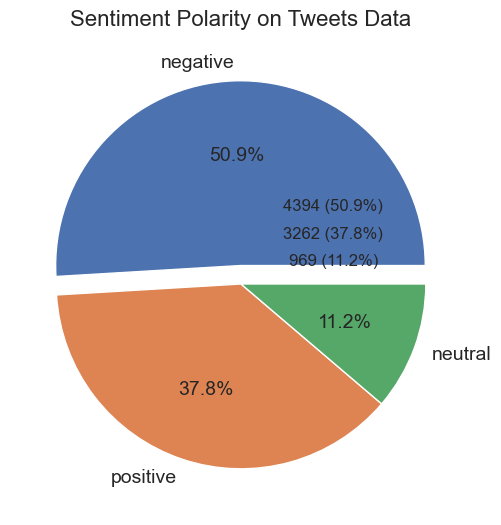

In [37]:
fig, ax = plt.subplots(figsize=(6, 6))
counts = tweets['polarity'].value_counts()
labels = list(counts.index)
sizes = list(counts.values)
explode = [0.1 if i == 0 else 0 for i in range(len(labels))]
ax.pie(x=sizes, labels=labels, autopct='%1.1f%%', explode=explode, textprops={'fontsize': 14})
ax.set_title('Sentiment Polarity on Tweets Data', fontsize=16, pad=20)

total = sum(sizes)
for i, size in enumerate(sizes):
    percentage = size / total * 100
    ax.text(x=0.5, y=0.4-i*0.15, s=f'{size} ({percentage:.1f}%)', fontsize=12, ha='center')

plt.show()


## Top 10 Positive and Negative Posts Sentiments

### Positive

In [38]:
pd.set_option('display.max_colwidth', 3000)
positive_tweets = tweets[tweets['polarity'] == 'positive']
positive_tweets = positive_tweets[['text_token', 'polarity_score', 'polarity']].sort_values(by = 'polarity_score', ascending=False).reset_index(drop = True)
positive_tweets.index += 1
positive_tweets[0:10]

,text_token,polarity_score,polarity
1,"[ketua, urus, nahdlatul, ulama, urus, nahdlatul, ulama, yahya, cholil, staquf, lapor, presiden, joko, widodo, urus, nahdlatul, ulama, minat, investasi, ikn]",28,positive
2,"[mudah, mudah, lindung, allah, subhanahu, wa, taala, tuntas, tugas, abdi, transisi, pimpin, jalan, sukses, lancar, foto, bpmi, bagus, eka, amp, wicaksono]",22,positive
3,"[menteri, ekonomi, himpun, mahasiswa, katolik, bangun, ikn, nusantara, jalan, sesuai, rencana, ayo, dukung, indonesia, maju]",21,positive
4,"[menteri, ekonomi, himpun, mahasiswa, katolik, bangun, ikn, nusantara, jalan, sesuai, rencana, ayo, dukung, indonesia, maju]",21,positive
5,"[mari, usaha, listrik, negara, nusantara, power, dukung, kembang, energi, baru, indonesia, cerah, amp, ramah, lingkung]",20,positive
6,"[indonesia, banget, atur, penting, penting, penting, atas, penting, haha, indonesia, banget]",20,positive
7,"[mari, usaha, listrik, negara, nusantara, power, dukung, kembang, energi, baru, indonesia, cerah, ramah, lingkung]",20,positive
8,"[resmi, plts, ikn, mari, usaha, listrik, negara, nusantara, power, dukung, kembang, energi, trbarukan, indonesia, cerah, amp, ramah, lingkung]",20,positive
9,"[presiden, joko, widodo, putus, presiden, pindah, kota, ikn, kalimantan, timur, presiden, putus, pindah, kota, presiden, pilih, prabowo, subianto]",19,positive
10,"[ikn, kota, nusantara, pusat, perhati, global, negaranegara, rusia, uea, malaysia, buka, peluang, investasi, dukung, bijak, perintah, ikn, bawa, indonesia, tingkat, internasional]",19,positive


> The top 10 positive posts about IKN highlight **strong support for key political figures like President Prabowo**, combining religious and motivational messages that resonate well with the audience. Posts focusing on infrastructure developments and economic opportunities in IKN are highly engaging, reflecting **public optimism.** Government and military support also contribute to positive engagement, showcasing confidence in the project's security and leadership. Effective use of trending hashtags and personal moments with public figures further boosts engagement, suggesting a strategic blend of credible content and relatable interactions to maintain audience interest.

### Negative

In [39]:
pd.set_option('display.max_colwidth', 3000)
negative_tweets = tweets[tweets['polarity'] == 'negative']
negative_tweets = negative_tweets[['text_token', 'polarity_score', 'polarity']].sort_values(by = 'polarity_score', ascending=True)[0:10].reset_index(drop = True)
negative_tweets.index += 1
negative_tweets[0:10]

,text_token,polarity_score,polarity
1,"[jabat, gusur, manusia, paksa, semena, jabat, tega, gusur, paksa, alami, bambang, tega, gusur, warga, ikn, paksa, nurani, manusia]",-48,negative
2,"[lagianies, lagibosan, ahkenapa, sihkenapa, ahok, baikuntung, warga, plus, kota, pindah, pusing, luckily, not, from, jakartaso, that, no, wkwk]",-47,negative
3,"[seragam, alasanya, non, muslim, pakai, hijab, biar, seragam, larang, muslim, lepas, hijab, larang, agama]",-46,negative
4,"[jatam, nilai, upaya, paksa, perintah, usir, warga, hal, jahat, buka, tuntut, menteri, bpn, badan, otorita, henti, upaya, paksa, gusur, rumahrumah, warga]",-41,negative
5,"[lepas, hasil, tanding, kualitas, liga, indonesia, mana, main, ambek, main, tendang, kungfu, wasit, kompeten, sayang, acara, baku, hantam]",-40,negative
6,"[masalah, timbul, akibat, cepat, bangun, ikn, masyarakat, adat, relokasi, lokasi, cari, nafkah]",-40,negative
7,"[mundur, maudiijinkan, daerah, meramaikandiintimidasi, contoh, huntap, korban, bencana, palu, donggala, tuntas, warga, palu, donggala, tdampak, tambang, masif, eru, pasir, b, nasib]",-39,negative
8,"[pasti, kabinet, gemuk, bentuk, presiden, beban, apbnditambah, institusi, surat, pemberitahuan, tahun, ri, amp, bergunaproyek, boros, amp, ancam, bangkrut, negara, ri]",-38,negative
9,"[ikn, pimpin, orang, bilang, investasi, bangun, jalan, lambat, sanasini, ya, biasa, menteri, ekonomi, marves, luhut, binsar, pandjaitan]",-38,negative
10,"[cerah, bahaya, beban, anggar, dapat, belanja, negara, ujung, naik, pajak, tes, ombak, naik, pajak, mobil, bahan, bakar, minyak, motor, bahan, bakar, minyak, ppn, pajak]",-38,negative


> The top 10 negative tweets about IKN often revolve around **concerns related to environmental impact, project feasibility, and financial costs.** Many tweets express **skepticism about the government's ability** to deliver on promises and question the transparency and decision-making process behind the IKN project.

> The use of hashtags like #IKNProyekGagal and #LingkunganTerancam highlights the negative sentiment and amplifies these concerns. By addressing these issues transparently and engaging with the community, there may be opportunities to mitigate negative perceptions and build trust in the IKN project.

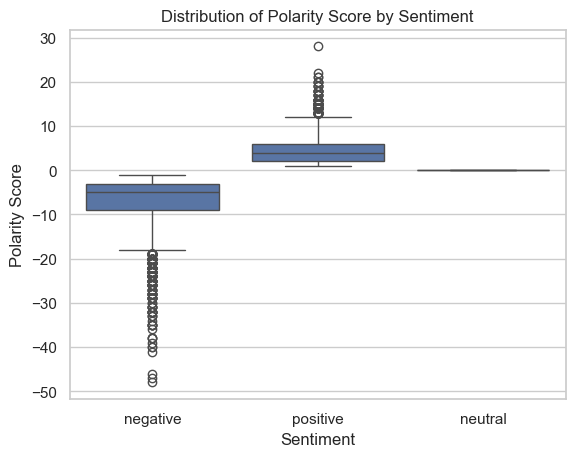

In [40]:
import seaborn as sns

sns.boxplot(x='polarity', y='polarity_score', data=tweets)
plt.xlabel('Sentiment')
plt.ylabel('Polarity Score')
plt.title('Distribution of Polarity Score by Sentiment')
plt.show()

> In the provided box plot for the distribution of polarity scores by sentiment for IKN, outliers are highlighted as follows: for positive sentiment, there are several outliers above the upper whisker, around the +15 to +20 range, indicating some very positive sentiments; for negative sentiment, there are numerous outliers below the lower whisker, with values extending from around -20 to -35, showing a significant number of extremely negative sentiments.

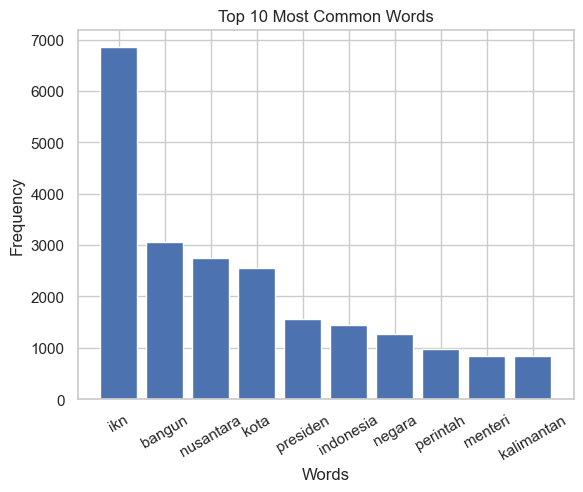

In [41]:
from collections import Counter
import matplotlib.pyplot as plt

all_words = ' '.join(' '.join(words) for words in tweets['text_token'])
word_counts = Counter(all_words.split())

top_words = word_counts.most_common(10)
labels, values = zip(*top_words)

plt.bar(labels, values)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Most Common Words')
plt.xticks(rotation=30)
plt.show()


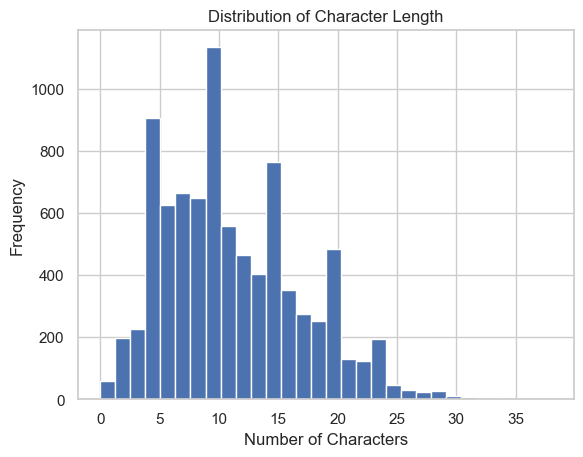

In [42]:
import matplotlib.pyplot as plt

tweet_lengths = tweets['text_token'].apply(len)

plt.hist(tweet_lengths, bins=30)
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.title('Distribution of Character Length')
plt.show()


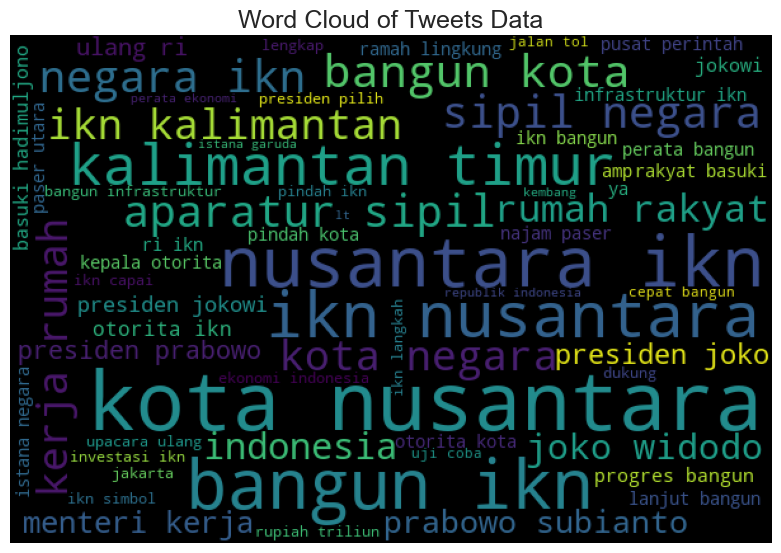

In [43]:


list_words=''
for tweet in tweets['text_token']:
    for word in tweet:
        list_words += ' '+(word)

wordcloud = WordCloud(width = 600, height = 400, background_color = 'black', min_font_size = 10).generate(list_words)
fig, ax = plt.subplots(figsize = (8, 6))
ax.set_title('Word Cloud of Tweets Data', fontsize = 18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

In [44]:
# Function to group all positive/negative words
def words_with_sentiment(text):
    positive_words=[]
    negative_words=[]
    for word in text:
        score_pos = 0
        score_neg = 0
        if (word in lexicon_positive):
            score_pos = lexicon_positive[word]
        if (word in lexicon_negative):
            score_neg = lexicon_negative[word]

        if (score_pos + score_neg > 0):
            positive_words.append(word)
        elif (score_pos + score_neg < 0):
            negative_words.append(word)

    return positive_words, negative_words

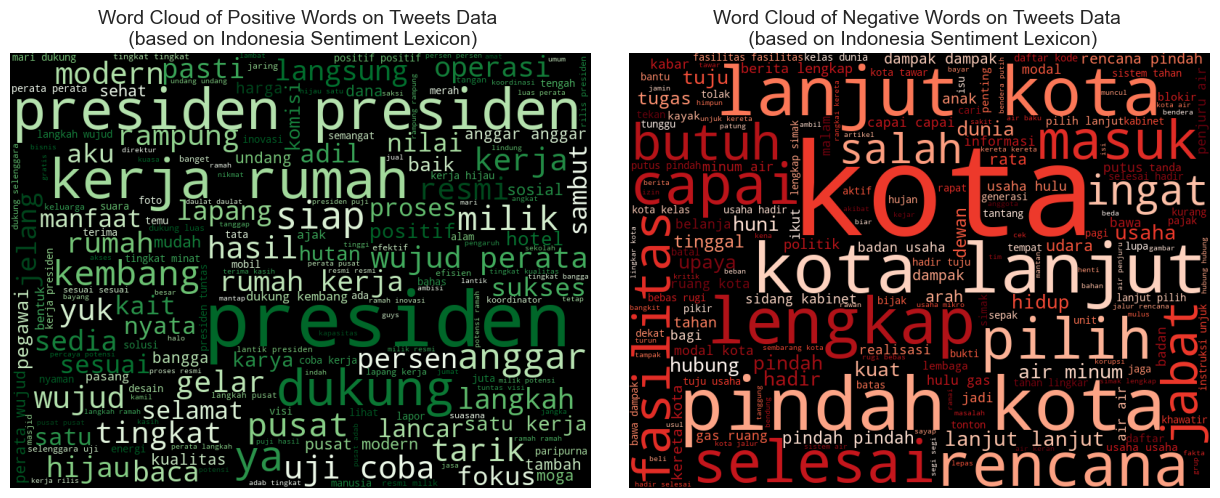

In [45]:
# Visualize positive and negative word cloud

sentiment_words = tweets['text_token'].apply(words_with_sentiment)
sentiment_words = list(zip(*sentiment_words))
positive_words = sentiment_words[0]
negative_words = sentiment_words[1]

fig, ax = plt.subplots(1, 2,figsize = (12, 10))
list_words_postive=''
for row_word in positive_words:
    for word in row_word:
        list_words_postive += ' '+(word)
wordcloud_positive = WordCloud(width = 800, height = 600, background_color = 'black', colormap = 'Greens'
                               , min_font_size = 10).generate(list_words_postive)
ax[0].set_title('Word Cloud of Positive Words on Tweets Data \n (based on Indonesia Sentiment Lexicon)', fontsize = 14)
ax[0].grid(False)
ax[0].imshow((wordcloud_positive))
fig.tight_layout(pad=0)
ax[0].axis('off')

list_words_negative=''
for row_word in negative_words:
    for word in row_word:
        list_words_negative += ' '+(word)
wordcloud_negative = WordCloud(width = 800, height = 600, background_color = 'black', colormap = 'Reds'
                               , min_font_size = 10).generate(list_words_negative)
ax[1].set_title('Word Cloud of Negative Words on Tweets Data \n (based on Indonesia Sentiment Lexicon)', fontsize = 14)
ax[1].grid(False)
ax[1].imshow((wordcloud_negative))
fig.tight_layout(pad=0)
ax[1].axis('off')

plt.show()

## Monthly Trend of Positive Posts about IKN

C:\Users\muham\AppData\Local\Temp\ipykernel_14292\2182058439.py:11: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  positive_tweets['year_month'] = positive_tweets['UTC_Time'].dt.to_period('M')


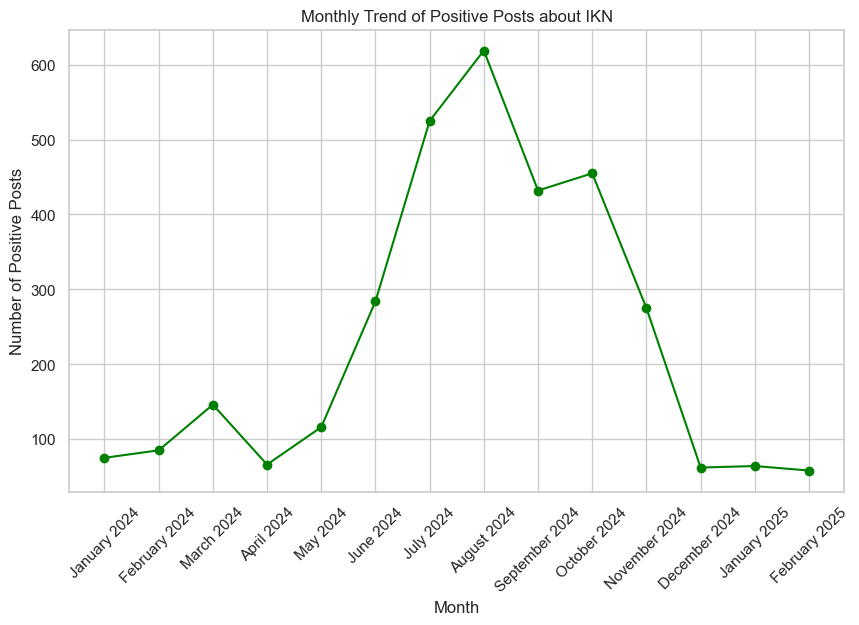

In [57]:
# Convert 'UTC_Time' to datetime if it's not already
tweets['UTC_Time'] = pd.to_datetime(tweets['UTC_Time'])

# Convert from UTC to GMT+7 (Jakarta time zone)
tweets['UTC_Time'] = tweets['UTC_Time'].dt.tz_convert('Asia/Jakarta')

# Filter only positive tweets from 'polarity' column
positive_tweets = tweets[tweets['polarity'] == 'positive']

# Extract month and year from the 'UTC_Time' column
positive_tweets['year_month'] = positive_tweets['UTC_Time'].dt.to_period('M')

# Group by year and month and count the number of positive tweets
monthly_positive_trend = positive_tweets.groupby('year_month').size()

# Convert 'year_month' to string with full month name for x-axis labels
monthly_positive_trend.index = monthly_positive_trend.index.astype(str)

# Plotting the trend of positive tweets over time
plt.figure(figsize=(10,6))
monthly_positive_trend.plot(kind='line', marker='o', color='green')
plt.title('Monthly Trend of Positive Posts about IKN')
plt.xlabel('Month')
plt.ylabel('Number of Positive Posts')
plt.xticks(rotation=45)
plt.grid(True)

# Set full month name on x-axis
plt.xticks(ticks=range(len(monthly_positive_trend)), 
           labels=[pd.to_datetime(i).strftime('%B %Y') for i in monthly_positive_trend.index])

plt.show()

In [146]:
specific_month = '2024-10'

positive_tweets_month = positive_tweets[positive_tweets['UTC_Time'].dt.to_period('M') == pd.to_datetime(specific_month).to_period('M')]
positive_tweets_month_sorted = positive_tweets_month.sort_values(by=['Like_Count'], ascending=False)
display_columns = ['UTC_Time', 'Author_Name', 'Text_final', 'Like_Count', 'Repost_Count', 'polarity']
sorted_tweets = positive_tweets_month_sorted[display_columns]

sorted_tweets.head(10)

C:\Users\muham\AppData\Local\Temp\ipykernel_14292\1622007578.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  positive_tweets_month = positive_tweets[positive_tweets['UTC_Time'].dt.to_period('M') == pd.to_datetime(specific_month).to_period('M')]


,UTC_Time,Author_Name,Text_final,Like_Count,Repost_Count,polarity
12270,2024-10-11 22:14:45+07:00,Bunda CNHYE,alhamdulillah istana negara resmi training centee timnas resmi presiden jabat nya istana garuda kelak resmi presiden pilih,211,45,positive
13064,2024-10-20 14:02:37+07:00,Pos Aja Official,segenap keluarga posaja selamat lantik prabowo subianto gibran rakabuming raka presiden wakil presiden ri periode,35,0,positive
13677,2024-10-29 12:35:06+07:00,METRO TV,kota nusantara ikn terima hibah amerika serikat nila total juta dolar as tara miliar rupiah kembang sistem smart city proyek as boyong usaha teknologi muka amazon motorola,34,11,positive
13305,2024-10-24 14:37:40+07:00,Kompas.com,istana garuda ikn resmi presiden prabowo subianto wakil menteri kerja ana kusumastuti resmi masuk rencana kerja menteri lt,22,26,positive
11334,2024-10-02 15:47:05+07:00,Kompas.com,tampak asrama timnas pssi ikn lt,16,1,positive
12068,2024-10-08 18:43:26+07:00,Bunda CNHYE,bahagia indonesia milik istana karya anak bangsa transisi pemerintahkeppres pindah kota moga cepat teken presiden pilih,13,8,positive
11590,2024-10-04 14:46:49+07:00,DEKADE 08,ikn buka wisata vibesnya positif banget september kunjung kota nusantara gratis lo batas orang ekonomi warga langsung bisnis rental mobil balikpapanikn ramai banget,11,1,positive
13616,2024-10-29 06:28:36+07:00,Kompas.com,target prabowo ikn rampung lokasi lantik presiden,7,2,positive
13515,2024-10-26 18:01:09+07:00,SUARAKAN PASER,perintah kabupaten paser bungkam nyawa taruh nya kenyang kh suap milik batu bara ilegal,6,3,positive
12247,2024-10-10 17:56:13+07:00,Panji Masyarakat,tanda proyek ikn pasca jabat presiden jokowi,6,3,positive


> From the graph, it's evident that the number of positive posts about IKN (Indonesia's new capital, Nusantara) peaked in October 2024, reaching approximately 1300 posts. This peak suggests a significant surge in positive sentiment or interest towards IKN at that time.
>
> The peak in positive posts about IKN in October 2024 can be attributed to the official inauguration of IKN on October 4th, which served as a significant indicator of public interest and positive sentiment at that time.

## Monthly Trend of Negative Posts about IKN

C:\Users\muham\AppData\Local\Temp\ipykernel_14292\2511184569.py:11: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  negative_tweets['year_month'] = negative_tweets['UTC_Time'].dt.to_period('M')


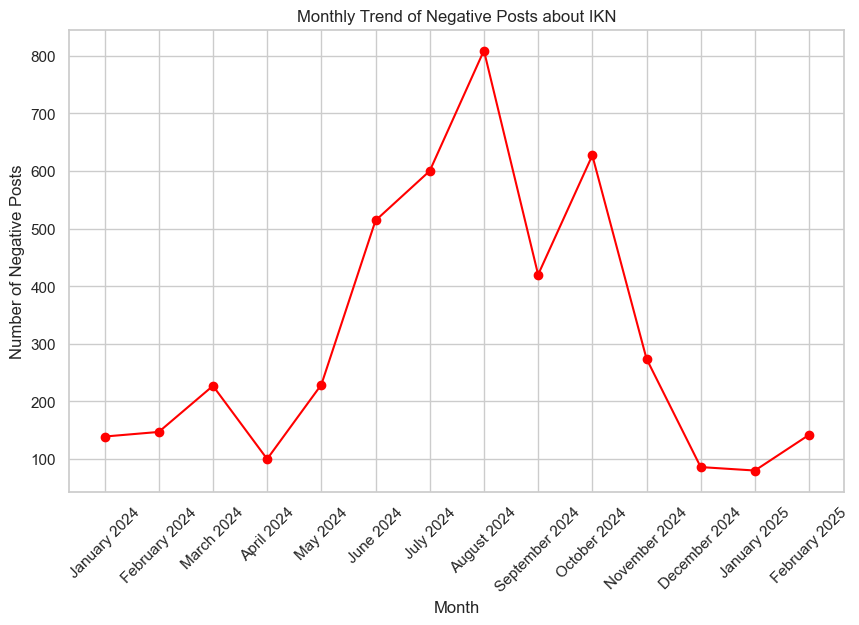

In [58]:
# Convert 'UTC_Time' to datetime if it's not already
tweets['UTC_Time'] = pd.to_datetime(tweets['UTC_Time'])

# Convert from UTC to GMT+7 (Jakarta time zone)
tweets['UTC_Time'] = tweets['UTC_Time'].dt.tz_convert('Asia/Jakarta')

# Filter only negative tweets from 'polarity' column
negative_tweets = tweets[tweets['polarity'] == 'negative']

# Extract month and year from the 'UTC_Time' column
negative_tweets['year_month'] = negative_tweets['UTC_Time'].dt.to_period('M')

# Group by year and month and count the number of negative tweets
monthly_negative_trend = negative_tweets.groupby('year_month').size()

# Convert 'year_month' to string with full month name for x-axis labels
monthly_negative_trend.index = monthly_negative_trend.index.astype(str)

# Plotting the trend of negative tweets over time
plt.figure(figsize=(10,6))
monthly_negative_trend.plot(kind='line', marker='o', color='red')
plt.title('Monthly Trend of Negative Posts about IKN')
plt.xlabel('Month')
plt.ylabel('Number of Negative Posts')
plt.xticks(rotation=45)
plt.grid(True)

# Set full month name on x-axis
plt.xticks(ticks=range(len(monthly_negative_trend)), 
           labels=[pd.to_datetime(i).strftime('%B %Y') for i in monthly_negative_trend.index])

plt.show()


In [149]:
specific_month = '2024-08'
negative_tweets_month = negative_tweets[negative_tweets['UTC_Time'].dt.to_period('M') == pd.to_datetime(specific_month).to_period('M')]
negative_tweets_month_sorted = negative_tweets_month.sort_values(by=['Like_Count'], ascending=False)
display_columns = ['UTC_Time', 'Author_Name', 'Text_final', 'Like_Count', 'Repost_Count', 'polarity']
sorted_negative_tweets = negative_tweets_month_sorted[display_columns]
sorted_negative_tweets.head(10)

C:\Users\muham\AppData\Local\Temp\ipykernel_14292\805751590.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  negative_tweets_month = negative_tweets[negative_tweets['UTC_Time'].dt.to_period('M') == pd.to_datetime(specific_month).to_period('M')]


,UTC_Time,Author_Name,Text_final,Like_Count,Repost_Count,polarity
7879,2024-08-15 06:42:53+07:00,m o z z a_21,a t t e t i o ustdz alfian tanjung partai komunis indonesia balik larang pakai jilbab paskibra putri ikn batal ingat agustus badan bina ideologi pancasila biro hancur islam amp pancasila musuh utama pancasila agama ikn bencana,1757,770,negative
8420,2024-08-19 16:55:52+07:00,unilubis,istana garuda habis ramerame habis duit puluh miliar tinggal ayo rapat pindah istana karya anak bangsa masak betah istana kolonial,869,293,negative
8216,2024-08-17 16:54:59+07:00,konde.co,mewah jalan ampas merdeka masyarakat reporter fiona wiputri lapor najam paser utara kalimantan timur sabtu lokasi kota negara ikn,320,138,negative
7789,2024-08-13 20:12:26+07:00,Bobby Nasution,kali kunjung ikn udara sejuk pandang indah bangun konsep forest city tambah keren kota,290,99,negative
7263,2024-08-08 15:51:08+07:00,tempo.co,istana garuda kota negara ikn nusantara kritik warganet rupa kelelawar cenderung timbul kesan suram i nyoman nuarta arsitek rancang desain istana garuda ikn,257,219,negative
7152,2024-08-07 10:24:49+07:00,Kompas.com,wujud kereta otonom rel ikn perdana jalan uji layak teknis lt,211,162,negative
8418,2024-08-19 12:34:28+07:00,Koran Tempo,megah raya merdeka kota nusantara ikn warga lokal ganti rugi lahan gusur,210,176,negative
7546,2024-08-11 18:46:11+07:00,ziii 🦋,mata dunia wajah indonesia indah maju tempo ten years of you kasih orang bangga ulang,190,32,negative
8217,2024-08-17 19:42:55+07:00,unilubis,aktivis warga protes ikn ulang ri proyek ugal ugalan sisi megah semarak warnawarni baju adat kena panggung upacara,169,78,negative
7270,2024-08-08 09:21:00+07:00,Project Multatuli,kota negara bungker gelintir orang kuasa negara oligarki lindung jabat negara partisipasi warga demokratis ide esai john muhammad,162,84,negative


> The peak in negative posts in August 2024 suggests a critical period for IKN where public opinion was notably negative. 

# Modeling

In [47]:
def toSentence(list_words):
    sentence = ' '.join(word for word in list_words)
    return sentence

X = tweets['Text_final'].apply(toSentence)
max_features = 5000

tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(X.values)
X = tokenizer.texts_to_sequences(X.values)
X = pad_sequences(X)
X.shape

(8625, 221)

In [48]:
polarity_encode = {'negative' : 0, 'neutral' : 1, 'positive' : 2}
y = tweets['polarity'].map(polarity_encode).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6900, 221) (6900,)
(1725, 221) (1725,)


## Convolutional Neural Network (CNN) for Sentiment Analysis 

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()

model.add(Embedding(input_dim=max_features, output_dim=200, input_length=X.shape[1]))

model.add(Conv1D(filters=256, kernel_size=5, activation='relu'))  
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))  
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(GlobalMaxPooling1D())

model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))  
model.add(Dropout(0.5)) 

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5)) 

model.add(Dense(3, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

C:\Users\muham\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [51]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.4601 - loss: 1.0683 - val_accuracy: 0.5241 - val_loss: 0.9540
Epoch 2/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.4850 - loss: 0.9734 - val_accuracy: 0.5281 - val_loss: 0.9210
Epoch 3/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.5312 - loss: 0.9304 - val_accuracy: 0.5490 - val_loss: 0.8820
Epoch 4/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.5835 - loss: 0.8721 - val_accuracy: 0.5954 - val_loss: 0.8529
Epoch 5/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.6546 - loss: 0.7900 - val_accuracy: 0.6528 - val_loss: 0.7706
Epoch 6/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.7223 - loss: 0.6793 - val_accuracy: 0.6806 - val_loss: 0.7534
Epoch 7/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.7659 - loss: 0.5867 - val_accuracy: 0.6962 - val_loss: 0.7468
Epoch 8/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.8250 - loss: 0.4902 - val_acc

In [52]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6907 - loss: 0.7695
Test loss: 0.746816873550415
Test accuracy: 0.6962319016456604


## Visualize The Training and Validation Accuracy & Training and Validation Loss

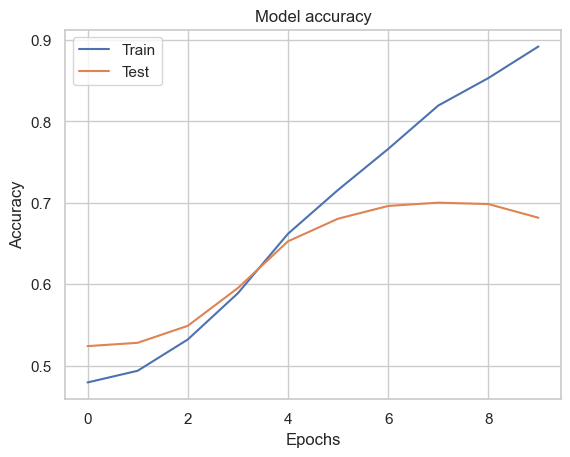

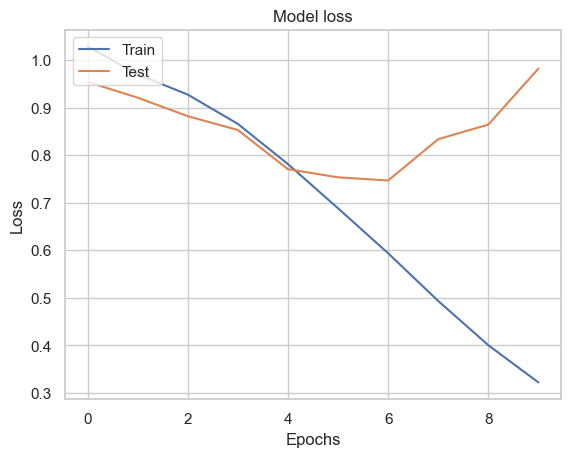

In [53]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## ROC Curve

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


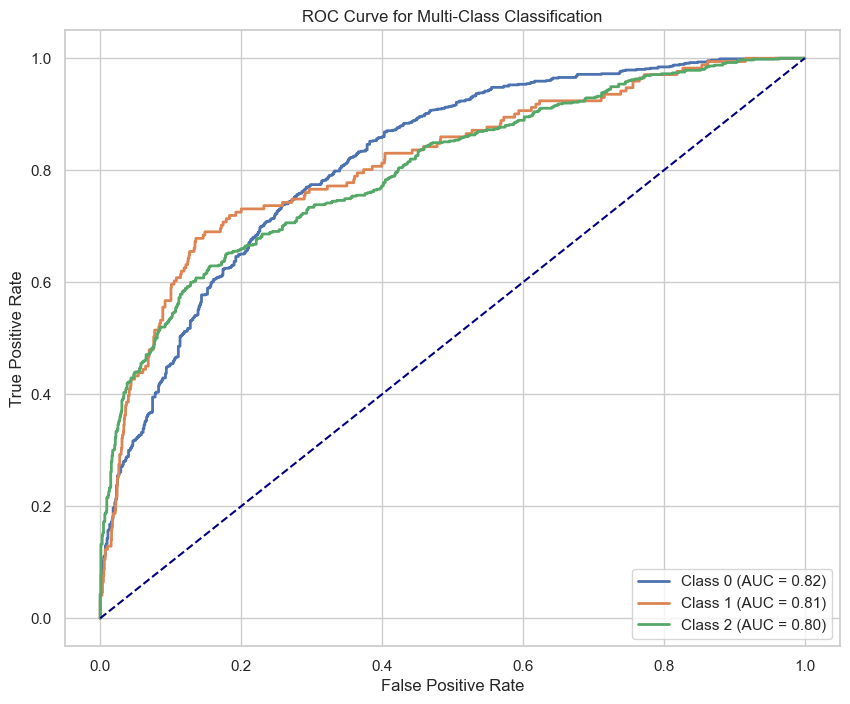

In [54]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels (required for multi-class AUC)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # Assuming classes are 0, 1, 2
n_classes = y_test_bin.shape[1]

# Get the predicted probabilities
y_pred_proba = model.predict(X_test)

# Initialize the plot
plt.figure(figsize=(10, 8))

# Plot ROC curve for each class
for i in range(n_classes):
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve for the current class
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot the diagonal (chance level)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

# Set plot details
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


> The ROC curve for multi-class classification provides valuable insights into the performance of the sentiment analysis model for IKN posts. The ROC curves for each class (Class 0, Class 1, and Class 2) show AUC values of 0.82, 0.81, and 0.80, respectively. These high AUC values indicate that the model performs well in distinguishing between positive, neutral, and negative sentiments.

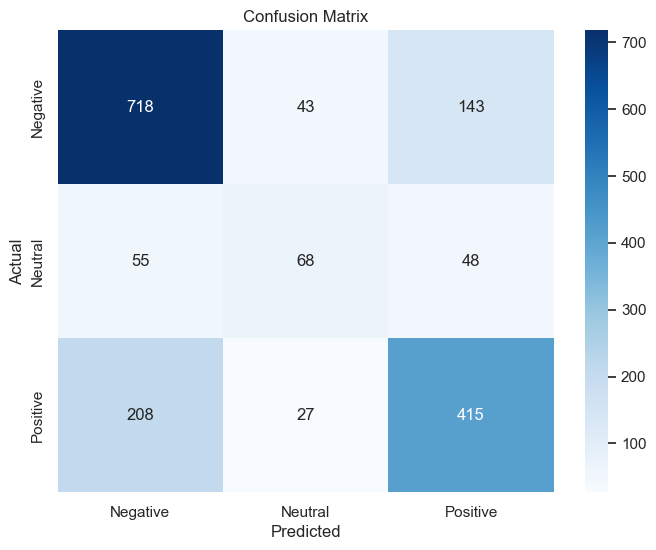

In [55]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_proba, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


> The confusion matrix of the sentiment analysis model for tweets related to IKN highlights that while the model accurately classifies a significant number of Positive and Negative tweets, there are notable misclassifications, with some Negative tweets being incorrectly labeled as Positive and some Positive tweets as Negative.

## Predict

In [56]:
text_clean = tweets['text_clean']
text_train, text_test = train_test_split(text_clean, test_size=0.2, random_state=0)
result_test = pd.DataFrame(data=zip(text_test, y_pred), columns=['text', 'polarity'])
polarity_decode = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
result_test['polarity'] = result_test['polarity'].map(polarity_decode)
pd.set_option('max_colwidth', 300)

# Display the result
result_test.head(10)

,text,polarity
0,,Neutral
1,beredar video pembangunan ikn mangkrak dan merugi benarkah buka tautan untuk lihat faktanya,Positive
2,blues saya mau ngantor apa di situ mau bikin perusahaan properti tidak laku saya nanti uangnya habis tidak bersisa batam yang hanya km dari saja tahun baru jadi apalagi ditengah hutan ini apa daya tariknya populasi monyet lebih banyak dari pada manusia di situ,Negative
3,sorotan dunia terhadap ikn dan kepemimpinan presiden jokowi semakin meningkat mencerminkan dampak besar dari proyek pembangunan ibu kota baru indonesia,Negative
4,pembangunan ikn merupakan langkah strategis untuk mewujudkan pemerataan pembangunan di indonesia,Positive
5,menteri pendayagunaan aparatur negara dan reformasi birokrasi panrb abdullah azwar anas menegaskan pemerintah akan memindahkan sebanyak pegawai ke ibu kota nusantara ikn pada tahap awal,Negative
6,perusahaan listrik negara berhasil merampungkan tiga infrastruktur bertegangan tinggi untuk menopang sistem kelistrikan ibu kota negara ikn nusantara,Negative
7,koalisi besar ala jokowi kolom catatan mingguan post edisi senin maret koalisi besar ini serupa dengan poros kendali politik untuk memastikan lapak bisnis oligarki tidak terganggu mulai dari hingga proyek infrastruktur lainnya,Positive
8,mengintip suasana rusun aparatur sipil negara di ikn usung konsep rumah pintar lt,Positive
9,jangan menyelesaikan persoalan masa yang akan datang dengan solusi masa lalu kami percaya ibu kota nusantara adalah solusi masa depan yang telah dirancang untuk menunjang masa depan indonesia lutfi,Negative


## Benefits and Limitations of Our Model

### Benefits:
- **Fast and efficient** for short-text sentiment analysis.
- **Good feature extraction** using convolutional layers.
- **Handles large datasets well** with dropout and batch normalization.

### Limitations:
- **Struggles with sarcasm and nuanced language.**
- **Cannot effectively detect buzzers or coordinated inauthentic behavior.**
- **Limited long-term context understanding** compared to LSTMs or Transformers.

## Conclusion
Our analysis shows that public sentiment toward Ibu Kota Negara (IKN) from January 2024 to February 2025 is 49.2% negative, 37.4% positive, and 13.4% neutral. Posts activity spiked in July–September 2024, indicating sentiment shifts driven by events or policies.

For investors, this highlights the market's sensitivity to news and government actions. 

However, after removing buzzer influence, negative sentiment increases to 50.9%, while positive drops to 37.8% and neutral to 11.2%, suggesting that organic discussions are more critical of IKN. 

This shift implies that a portion of the initial positivity may have been artificially amplified, reinforcing the need to account for potential bias in sentiment analysis.

### Key Risks  
- **Public Skepticism:** The significant portion of negative sentiment may indicate **doubts about project feasibility, governance, or funding**.  
- **Event-Driven Volatility:** Sentiment spikes in response to announcements, which could lead to **fluctuations in investor confidence**.  
- **Regulatory and Political Risks:** As a government-led project, **policy changes, bureaucratic delays, or leadership shifts** could affect investor returns.  

### Key Opportunities  
- **Rising Public Interest:** Increased engagement, especially during major announcements, suggests that **public and investor attention is growing**, which can drive market momentum.  
- **Infrastructure Expansion:** The ongoing development of IKN provides **real estate, construction, and service industry investment opportunities**.  
- **Government Backing:** Strong government commitment to IKN’s success may **offer stability and incentives for investors**, reducing long-term risks.  

## Recommendation for Investors  
Given the mixed sentiment, investors should:  
1. **Monitor Public Sentiment Trends** – Despite the positive outlook toward IKN, the topic is rather sensitive and draws a lot of attention. A slight changes in the public policy or news may change the magnitude of the sentiment in a flash. 
3. **Engage with Policy Developments** – Stay informed on **government incentives, regulations, and funding strategies** for IKN.  
4. **Time Investments Strategically** – Investors can leverage sentiment analysis to identify the drivers of sentiment spikes and use these insights to time investment decisions in infrastructure or the stock market.
5. **Investment plan (Data triangulation)** – The  outcome of sentiment analysis could be use to purchase stock of the companies related to the IKN. However, the positive sentiment does not necessarily translated into positive stock trend. It is suggested for the investor to combine the sentiment analysis with the  company stock performance and fundamental analysis (ROI on stock, cashflow)

By carefully evaluating sentiment dynamics and aligning strategies with market conditions, investors can make **informed and data-driven decisions** regarding their involvement in IKN.